## Statistics Binning

In [1]:
#dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist
from scipy.stats import binned_statistic_2d as bsd

#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
import figurefirst
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

#misc
import time
np.set_printoptions(suppress=True)

In [2]:
def get_particle_statistics(x,y,wind_speed):
    x,y= np.array([x,y]).astype(int)
    if (wind_speed <= 3):
        log_whiff = LW1[y][x]
        ef = LW2[y][x]
        ma = LW3[y][x]
        return log_whiff, ef, ma
    else:
        log_whiff = HW1[y][x]
        ef = HW2[y][x]
        ma = HW3[y][x]
        return log_whiff, ef, ma
        

In [5]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'
df = pd.read_hdf(dir+'Windy/WindyIF.h5')

### Calculation of Binned Statistics based on Distance

In [23]:
x = np.linspace(0,40,41)
y = np.linspace(0,13,13)

## Whiff Duration
LW1 , x1, y1, binno1 = bsd(df.avg_dist_from_source, df.avg_dist_from_streakline, df.log_whiff, 
                       statistic = 'mean', bins=(x,y), expand_binnumbers=True)
## Encounter Frequency
LW2 , x2, y2, binno2 = bsd(df.avg_dist_from_source, df.avg_dist_from_streakline, df.mean_encounter_frequency, 
                       statistic = 'mean', bins=(x,y), expand_binnumbers=True)
## Moving Avg
LW3 , x3, y3, binno3 = bsd(df.avg_dist_from_source, df.avg_dist_from_streakline, df.mean_ma, 
                       statistic = 'mean', bins=(x,y), expand_binnumbers=True)


LW1 = LW1.T
# LW1[np.isnan(LW1)] = 0
LW2 = LW2.T
# LW2[np.isnan(LW2)] = 0
LW3 = LW3.T
# LW3[np.isnan(LW3)] = 0

In [24]:
get_particle_statistics(0,0,2) ## Initial function to pole statistics from available data

(-1.3412167271403745, 1.9096473784628505, 32.91943172526945)

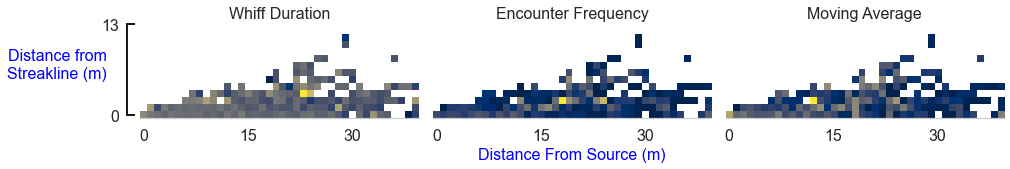

In [39]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize =(14,10))
extent=[x1[0], x1[-1], y1[0], y1[-1]]

ax1.imshow(LW1, interpolation='nearest', origin='lower',cmap = 'cividis')
ax2.imshow(LW2, interpolation='nearest', origin='lower',cmap = 'cividis')
ax3.imshow(LW3, interpolation='nearest', origin='lower',cmap = 'cividis')

ax1.set_ylabel('Distance from\nStreakline (m)' , fontsize = 13, rotation = 0, color = 'blue')

ax1.yaxis.set_label_coords(-0.3, 0.4)
ax1.spines['left'].set_visible(False)
ax2.set_xlabel('Distance From Source (m)' , fontsize = 13, color='blue')

add_label_band(ax1, 0, 13, " " )
condition_plot(ax1, df.avg_dist_from_streakline)
ax1.tick_params(axis='y', which='major', pad=15)
condition_plot(ax2, df.avg_dist_from_streakline)
remove_tick_labels(ax2)
condition_plot(ax3, df.avg_dist_from_streakline)
remove_tick_labels(ax3)

ax1.title.set_text('Whiff Duration')
ax2.title.set_text('Encounter Frequency')
ax3.title.set_text('Moving Average')

figurefirst.mpl_functions.set_fontsize(f, 16)
f.tight_layout()

f.savefig('../../Figure/OS_HW.jpeg', bbox_inches='tight', dpi=600) 

### Encounter Probability Mapping

In [69]:
query = 'odor>=2'
df_occurence = df.query(query)

x = np.linspace(0,25,30)
y = np.linspace(0,13,20)

H1, x, y = np.histogram2d(df_occurence.distance_from_source_, df_occurence.nearest_from_streakline_, bins=(x, y), 
                          weights = df_occurence.odor)
H1 = H1.T 
H2, x, y = np.histogram2d(df.distance_from_source_, df.nearest_from_streakline_, bins=(x, y), 
                          weights = df.odor)
H2 = H2.T 
Encounters = np.array(H1)/np.array(H2)
Encounters[Encounters == np.inf] = 0

<ipython-input-69-1b2df05e5d29>:13: RuntimeWarning: invalid value encountered in true_divide
  Encounters = np.array(H1)/np.array(H2)


In [70]:
#filtering
Total = H2
N_Encounter = H1
for i in range (len(Total)):
    for j in range(len(Total[i])):
        if Total[i][j]<400:
            Total[i][j] =0
            N_Encounter[i][j]=0

Encounters = np.array(N_Encounter)/np.array(Total)
Encounters[Encounters == np.inf] = 0

<ipython-input-70-4e1cd30133a5>:10: RuntimeWarning: invalid value encountered in true_divide
  Encounters = np.array(N_Encounter)/np.array(Total)


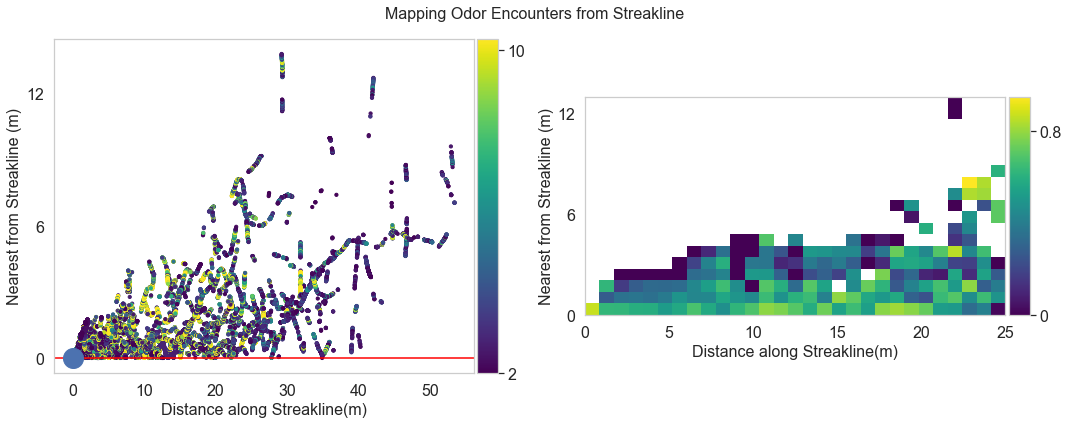

In [72]:
f, (ax1,ax2) = plt.subplots(1,2, figsize =(15,6) , gridspec_kw={'width_ratios': [4,4]})

#plot wind vs odor from source and each other
f.suptitle('Mapping Odor Encounters from Streakline')
ax1.axhline(0, color = 'red')
ax1.plot(0,0,'o', markersize = 20)
var = ax1.scatter(df_occurence.distance_from_source_, df_occurence.nearest_from_streakline_, cmap = 'viridis', 
                  c = df_occurence.odor,  s = 10)
ax1.set_xlabel('Distance along Streakline(m)' , fontsize = 13)
ax1.set_ylabel('Nearest from Streakline (m)' , fontsize = 13)
ax1.set_yticks([0,6,12])


divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar1=f.colorbar(var, cax=cax, orientation = 'vertical', ticks=[2.01,10])
cbar1.ax.set_yticklabels(['2', '10'])


ax2.set_xlabel('Distance along Streakline(m)', fontsize = 13)
ax2.set_ylabel('Nearest from Streakline (m)', fontsize = 13)
var2 = ax2.imshow(Encounters, interpolation='nearest', origin='lower',cmap = 'viridis', extent=[x[0], x[-1], y[0], y[-1]])
ax2.set_yticks([0,6,12])


divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = f.colorbar(var2, cax=cax, orientation = 'vertical', ticks=[0,0.8])
cbar.ax.set_yticklabels(['0', '0.8'])

figurefirst.mpl_functions.set_fontsize(f, 16)
f.tight_layout()
f.savefig('../../Figure/probabilityEnc.jpeg', bbox_inches='tight', dpi=400) 